In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = os.path.abspath('../../data/stanfordSentimentTreebank/')

In [164]:
fn.frame_relation_types()

dict_values([<frame relation type (10): Causative -- Causative_of -> Inchoative/state>, <frame relation type (9): Inchoative -- Inchoative_of -> Stative>, <frame relation type (1): Parent -- Inheritance -> Child>, <frame relation type (13): Source -- Metaphor -> Target>, <frame relation type (12): Neutral -- Perspective_on -> Perspectivized>, <frame relation type (11): Earlier -- Precedes -> Later>, <frame relation type (5): Source -- ReFraming_Mapping -> Target>, <frame relation type (4): MainEntry -- See_also -> ReferringEntry>, <frame relation type (2): Complex -- Subframe -> Component>, <frame relation type (3): Parent -- Using -> Child>])

In [168]:
subframe_rels = fn.frame_relations(type='Subframe')

In [171]:
sr = subframe_rels[0]

In [176]:
sr.keys()

dict_keys(['subID', 'supID', 'subFrameName', 'superFrameName', 'ID', '_type', 'feRelations', 'type', 'superFrame', 'Complex', 'subFrame', 'Component'])

In [158]:
fn.frames_by_lemma('educating')

[]

In [3]:
train_ds = pd.read_csv(DATA_DIR+'/imdb_train_with_preds.csv', index_col=0)
print(train_ds.shape)
train_ds.head()

(25000, 772)


,sentiment,text,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767,sentiment_bin,prediction
0,pos,"Since Educating Rita, Julie Walters has been o...",-0.217232,-0.278537,0.024592,-0.190077,0.338728,0.198379,0.155497,0.505957,...,-0.048404,-0.267151,-0.375385,-0.221558,0.410194,-0.030859,0.250553,0.060898,True,True
1,pos,This is one of the best movies out there and t...,-0.052009,-0.275612,0.290984,0.037968,0.363718,0.050480,0.126078,0.849306,...,0.008719,-0.378950,-0.302224,0.030559,0.274638,-0.174276,0.252467,-0.049769,True,True
2,pos,Dumland focuses on the lives of one (American?...,-0.169023,-0.005889,0.382560,-0.115467,0.296713,0.063204,0.051784,0.567073,...,0.170062,-0.453052,-0.073050,-0.352005,0.217358,0.124859,0.451700,0.174639,True,True
3,pos,At one end of the Eighties Warren Beatty creat...,-0.104024,0.118619,0.313575,0.005333,0.251248,-0.109587,-0.155153,0.548621,...,0.189538,-0.187595,-0.031585,-0.204041,0.114504,-0.136630,0.328830,0.035915,True,True
4,pos,An excellent movie about two cops loving the s...,-0.290859,-0.307483,0.359930,0.252686,0.421740,0.044342,0.123191,0.444648,...,0.066162,-0.316122,-0.594344,0.089560,0.260170,-0.233630,0.373538,0.026722,True,True


In [6]:
import re

In [7]:
import nltk

In [8]:
from nltk.corpus import framenet as fn

In [9]:
from nltk.stem import WordNetLemmatizer

In [10]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [11]:
wordnet_lemmatizer = WordNetLemmatizer()

In [12]:
#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))
print("Lancaster Stemmer")
print(lancaster.stem("cats"))
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

Porter Stemmer
cat
troubl
troubl
troubl
Lancaster Stemmer
cat
troubl
troubl
troubl


In [13]:
import seaborn as sns

In [14]:
def get_frames_from_txt(txt, count_thold=None):
    ws = re.split('\s', txt)
    frs = [fr['ID'] for w in ws for fr in fn.frames_by_lemma(porter.stem(w))]
    frs = pd.Series(frs).value_counts()
    if count_thold is not None:
        frs = frs[frs>=count_thold]
    frs = [fn.frame_by_id(fr)['name'] for fr in frs.index]
    return frs

In [181]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
len(get_frames_from_txt(txt))

1010

In [16]:
len(get_frames_from_txt(txt,20))

17

In [110]:
cds = train_ds.sample(5000)

In [111]:
cds['sentiment_bin'].mean()

0.504

In [112]:
from tqdm.notebook import tqdm

In [113]:
bin_ds = pd.DataFrame(columns=[fr['name'] for fr in fn.frames()])
for idx, row in tqdm(cds.iterrows(), total=len(cds)):
    txt = row['text']
    txt = ' '.join(re.findall('\w+', txt))
    frs = get_frames_from_txt(txt, 20)
    bin_ds.loc[idx] = pd.Series({fr:True for fr in frs})
bin_ds = bin_ds.fillna(False)

In [114]:
bin_ds.to_csv(DATA_DIR+'/bin_ds_frames.csv')

In [115]:
bin_ds_pos = bin_ds[cds['sentiment_bin']==1]
bin_ds_neg = bin_ds[cds['sentiment_bin']==0]

In [116]:
bin_ds_pos.index = bin_ds_pos.index.astype(str)
bin_ds_neg.index = bin_ds_neg.index.astype(str)
bin_ds.index = bin_ds.index.astype(str)

In [117]:
bin_ds_pos.shape

(2520, 1221)

In [118]:
bin_ds_pos.drop_duplicates().T.drop_duplicates().T.shape

(2427, 1051)

In [119]:
import sys

In [120]:
from lib import fca_interp as fcai

In [121]:
from importlib import reload

In [122]:
fcai = reload(fcai)

In [123]:
cntx_full = fcai.BinaryContext(bin_ds)

In [124]:
cntx_pos = fcai.BinaryContext(bin_ds_pos)

In [125]:
fm = fcai.FormalManager(cntx_pos, context_full=cntx_full)

In [126]:
max_cncpts = []
for g in cntx_pos.get_objs(is_full=False):
    int_ = cntx_pos.get_intent([g], is_full=True)
    ext_ = cntx_pos.get_extent(int_,is_full=True)
    c = fcai.Concept(ext_, int_)
    max_cncpts.append(c)
max_cncpts = fm.get_unique_concepts(max_cncpts)

In [127]:
fm._concepts = max_cncpts

In [128]:
fm.calc_strongness()

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



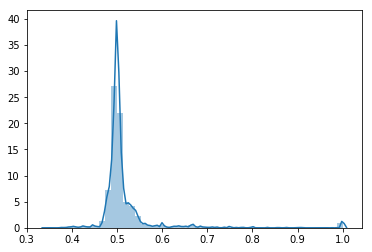

In [194]:
sns.distplot([c._metrics['strongness'] for c in fm.get_concepts()])

In [201]:
basic_concepts = fm.get_concepts()

In [209]:
strong_concepts = [c for c in fm.get_concepts() if c._metrics['strongness']>=0.51]
len(strong_concepts)

647

In [210]:
fm._concepts = strong_concepts
for idx, c in enumerate(fm.sort_concepts(fm.get_concepts())):
    c._idx = idx

In [211]:
fm.construct_lattice(use_tqdm=True)

In [212]:
len(fm.get_concepts())

647

In [213]:
fm.calc_stability_approx()

/home/egor/Documents/hse_comp_ling/lib/fca_interp.py:721: RuntimeWarning:

overflow encountered in power

/home/egor/Documents/hse_comp_ling/lib/fca_interp.py:741: RuntimeWarning:

divide by zero encountered in log2

/home/egor/Documents/hse_comp_ling/lib/fca_interp.py:742: RuntimeWarning:

divide by zero encountered in log2



/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



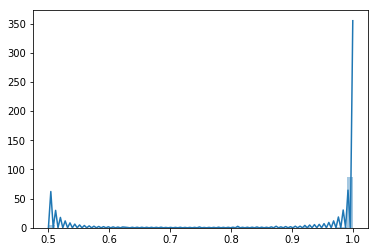

In [216]:
sns.distplot([c._metrics['stab_min_bound'] for c in fm.get_concepts() if c._metrics['stab_min_bound'] is not None])

In [237]:
fm.get_concept_by_id(100)._metrics

{'strongness': 0.5565068493150684,
 'stab_min_bound': 1.0,
 'stab_max_bound': 1.0,
 'log_stab_min_bound': inf,
 'log_stab_max_bound': inf,
 'lstab_min_bound': -1154.0}

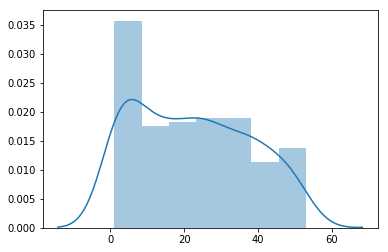

In [241]:
sns.distplot([c._metrics['log_stab_min_bound'] for c in fm.get_concepts() if c._metrics['log_stab_min_bound'] is not None and c._metrics['log_stab_min_bound'] <np.inf])

In [249]:
stab_concepts = [c for c in fm.get_concepts() if c._metrics['log_stab_min_bound'] is not None and c._metrics['log_stab_min_bound']>500]
len(stab_concepts)

282

In [250]:
stab_concepts

[Concept 7
 level: 0
 extent (len: 1150): 12209, 911, 5543, 7761, 4776, 7072, 6491, 3816, 1269, 4415, 3591, 5199, 6739, 10685, 10302, 3415, 7517, 10676, 32, 12089, 1337, 6798, 2739, 10560, 11464, 9375, 2112, 3154, 5516, 11122, 4421, 6703, 6989, 2535, 1433, 740, 2375, 4825, 6830, 3274, 9455, 4050, 11991, 3802, 5892, 9563, 5211, 6000, 7814, 11933, 6232, 9507, 11870, 4457, 639, 12059, 4397, 10701, 4257, 7531, 3224, 12288, 12449, 671, 2761, 12142, 195, 10543, 9371, 11070, 11619, 6530, 7518, 5798, 2894, 456, 424, 290, 8654, 888, 1619, 11883, 1748, 7650, 4075, 3576, 9545, 9667, 1795, 4529, 1583, 7210, 8422, 5821, 1826, 11974, 6731, 5234, 12219, 12161, 2042, 2811, 4720, 5963, 7130, 7371, 11867, 1604, 11664, 320, 9337, 1655, 3578, 871, 7047, 1285, 649, 2599, 2628, 5538, 3939, 7608, 10065, 10128, 9703, 4270, 3297, 6514, 12261, 2649, 8646, 5569, 2970, 3349, 9848, 477, 11208, 865, 8496, 11914, 5928, 1666, 5594, 6042, 8446, 5916, 7164, 7624, 9910, 1097, 644, 10792, 8770, 5524, 273, 11875, 2753, 84

In [133]:
import networkx as nx

In [134]:
fig = fm.get_plotly_fig(color_by='strongness')

In [191]:
[c._metrics['min_stab_bound'] for c in fm.get_concepts()]

KeyError: 'min_stab_bound'

In [92]:
c = fm.get_concept_by_id(35)

In [100]:
int_ = c.get_intent()
int_short = int_.copy()
for i in tqdm(range(len(int_short))):
    if len(int_short)>=i:
        break
        
    for m in int_short:
        int_new = [m_ for m_ in int_short if m_!=m]
        int_new_ = cntx_full.get_intent(cntx_full.get_extent(int_new, is_full=True), is_full=True)
        if len(int_new_)==len(int_):
            int_short = int_new
            break

In [99]:
len(int_short)

512

In [95]:
len(int_new)

511

In [97]:
len(cntx_pos.get_intent(cntx_pos.get_extent(int_new), is_full=True))

512

In [142]:
docs = fn.docs()
len(docs)

107

In [147]:
doc = docs[1]

In [154]:
doc.keys()

dict_keys(['_type', 'sentence', 'description', 'name', 'ID', 'filename', 'URL', 'corpname', 'corpid'])